In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/image_course/quiz1
Path = '/content/drive/MyDrive/image_course/quiz1/'

/content/drive/MyDrive/image_course/quiz1


In [ ]:
!pip install -qq transformers accelerate

In [ ]:
import gensim
import gensim.downloader as api
import pandas as pd
import re
from nltk import ngrams
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.isri import ISRIStemmer
import nltk
import re
import random
nltk.download('stopwords')
nltk.download('punkt')
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset
import transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments, pipeline
from transformers.data.processors.utils import InputFeatures


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
## Setting Device

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
## Seeding RNGs for reproducible training

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
print(torch.__version__)
print(transformers.__version__)

2.5.0+cu121
4.46.2


In [ ]:
DATASET_PATH = Path+'Dataset.tsv'
df = pd.read_csv(DATASET_PATH,sep='\t')
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   99999 non-null  object
 1   text    99999 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


In [ ]:
df.head(n=10)

,label,text
0,Positive,ممتاز نوعا ما . النظافة والموقع والتجهيز والشا...
1,Positive,أحد أسباب نجاح الإمارات أن كل شخص في هذه الدول...
2,Positive,هادفة .. وقوية. تنقلك من صخب شوارع القاهرة الى...
3,Positive,خلصنا .. مبدئيا اللي مستني ابهار زي الفيل الاز...
4,Positive,ياسات جلوريا جزء لا يتجزأ من دبي . فندق متكامل...
5,Positive,أسلوب الكاتب رائع جدا و عميق جدا، قرأته عدة مر...
6,Positive,استثنائي. الهدوء في الجناح مع مسبح. عدم وجود ع...
7,Positive,الكتاب هو السيرة الذاتية للحداثة في المملكة بل...
8,Positive,من أجمل ما قرأت.. رواية تستحق القراءة فعلا..
9,Positive,بشكل عام جيده .. . التجاوب جيد جدا من قبل موظف...


In [ ]:
df.head(n=10)

,label,text
0,Positive,ممتاز نوعا ما . النظافة والموقع والتجهيز والشا...
1,Positive,أحد أسباب نجاح الإمارات أن كل شخص في هذه الدول...
2,Positive,هادفة .. وقوية. تنقلك من صخب شوارع القاهرة الى...
3,Positive,خلصنا .. مبدئيا اللي مستني ابهار زي الفيل الاز...
4,Positive,ياسات جلوريا جزء لا يتجزأ من دبي . فندق متكامل...
5,Positive,أسلوب الكاتب رائع جدا و عميق جدا، قرأته عدة مر...
6,Positive,استثنائي. الهدوء في الجناح مع مسبح. عدم وجود ع...
7,Positive,الكتاب هو السيرة الذاتية للحداثة في المملكة بل...
8,Positive,من أجمل ما قرأت.. رواية تستحق القراءة فعلا..
9,Positive,بشكل عام جيده .. . التجاوب جيد جدا من قبل موظف...


In [ ]:
train_main, test_main = train_test_split(df, test_size=0.3, shuffle=True, random_state=SEED, stratify=df['label'])
label_list_main = list(df['label'].unique())

print("Training length: ", len(train_main))
print(train_main['label'].value_counts(), '\n')

print("Testing length: ", len(test_main))
print(test_main['label'].value_counts())

Training length:  69999
label
Positive    23333
Mixed       23333
Negative    23333
Name: count, dtype: int64 

Testing length:  30000
label
Positive    10000
Negative    10000
Mixed       10000
Name: count, dtype: int64


In [ ]:
label_list_df_main = list(df['label'].unique())
print(label_list_df_main)

['Positive', 'Mixed', 'Negative']


In [ ]:
class CustomDataset:

    def __init__(self, name: str, train: pd.DataFrame, test: pd.DataFrame, label_list: list[str]):
        self.name = name
        self.train = train
        self.test = test
        self.label_list = label_list

In [ ]:
data_main = CustomDataset('Arabic-Dataset', train_main, test_main, label_list_df_main)

In [ ]:
print(data_main.name)
print(data_main.label_list)
print("Number of Labels:", len(data_main.label_list))

Arabic-Dataset
['Positive', 'Mixed', 'Negative']
Number of Labels: 3


In [ ]:
def preprocess(text):
  # Remove HTML
  html_remover= re.compile('<.*?>')
  text = re.sub(html_remover, '', text)
  special_symbols_remover = re.compile('[?&#$%@*^]')
  text = re.sub(special_symbols_remover, '', text)
  return text

In [ ]:
data_main.train['text'] = data_main.train['text'].apply(preprocess)
data_main.test['text'] = data_main.test['text'].apply(preprocess)

In [ ]:
# Make sure cleaning didn't mess up any sample
nan_in_col = data_main.train[data_main.train['text'].isnull()]
nan_in_col

,label,text


In [ ]:
data_main.train.head(n=10)

,label,text
28509,Positive,خواطر رائعة وخلاصة تجارب وسلوكيات من اليابان ....
21094,Positive,عبد بنى قراره المصيري في حياته ومستقبله ليدعم ...
40933,Mixed,أول غلطة وقعت فيها ، إنى افتكرت إنى باقرا رواي...
2726,Positive,لا يحتاج . كل شى. لاشى
33091,Positive,بيقول : نظريه المؤامره لذيذه وتروق للجميع لانه...
43525,Mixed,حسن. فندق جميل.
80542,Negative,لا تقرب من هالفندق . الفطور مقبول وموقع الفندق...
9373,Positive,جيد. قرب الفندق من التوسعه الجديدة ومستوى النظ...
4690,Positive,يستاهل التجربة . قربه من الكورنيش وطريقة معامل...
6027,Positive,أعجبتني فكرة الكتاب للغاية و أدهشني ذلك الدويت...


In [ ]:
model_name = 'aubmindlab/bert-base-arabertv2'


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
tokenizer.tokenize("انا اسمي احمد")

['انا', 'اسمي', 'احمد']

In [ ]:
tokenizer.vocab_size

64000

In [ ]:
max_len = 512

print("Truncated training sequences: ", sum([len(tokenizer.tokenize(sentence)) > max_len for sentence in data_main.train['text'].to_list()]))
print("Truncated testing sequences: ", sum([len(tokenizer.tokenize(sentence)) > max_len for sentence in data_main.test['text'].to_list()]))

Token indices sequence length is longer than the specified maximum sequence length for this model (731 > 512). Running this sequence through the model will result in indexing errors


Truncated training sequences:  1600
Truncated testing sequences:  699


In [ ]:
# Creating a PyTorch dataset object to load the data into the Trainer API

class ClassificationDataset(Dataset):

    def __init__(self, text: list[str], target: list[str], model_name: str, max_len: int, label_map: dict[str, int]):
      super().__init__()

      self.text = text
      self.target = target
      self.tokenizer_name = model_name
      self.tokenizer = AutoTokenizer.from_pretrained(model_name)
      self.max_len = max_len
      self.label_map = label_map

    def __len__(self):
      return len(self.text)

    def __getitem__(self, item):
      text = str(self.text[item])
      text = " ".join(text.split())

      inputs = self.tokenizer(
          text,
          max_length=self.max_len,
          padding='max_length',
          truncation=True
      )

      # return input_ids, attention_mask, token_type_ids, label
      return InputFeatures(**inputs,label=self.label_map[self.target[item]])

In [ ]:
label_map = { v:index for index, v in enumerate(data_main.label_list) }
print(label_map)

{'Positive': 0, 'Mixed': 1, 'Negative': 2}


In [ ]:
max_len = 512

data_main.train = data_main.train[
    data_main.train.apply(lambda row: len(tokenizer.tokenize(row['text'])) <= max_len, axis=1)
]

In [ ]:
# Create train/test Pytorch datasets

train_dataset = ClassificationDataset(
    data_main.train['text'].to_list(),
    data_main.train['label'].to_list(),
    model_name,
    max_len,
    label_map
  )

test_dataset = ClassificationDataset(
    data_main.test['text'].to_list(),
    data_main.test['label'].to_list(),
    model_name,
    max_len,
    label_map
  )

print(train_dataset[0])

InputFeatures(input_ids=[33, 16286, 3428, 251, 13120, 454, 34925, 3293, 741, 28205, 4198, 210, 290, 4308, 16277, 48, 48, 2620, 210, 545, 2331, 289, 8952, 34, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31

In [ ]:
#len(train_dataset[0])

In [ ]:
input_ids = train_dataset[0].input_ids

tokenizer.decode(input_ids)

'[CLS] خواطر رائعة وخلاصة تجارب وسلوكيات من اليابان.. طبقت بعضها في حياتي [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [P

In [ ]:
# returns a pretrained model for finetuning in the trainer API
def model_init():
    model = AutoModelForSequenceClassification.from_pretrained(model_name, return_dict=True, num_labels=len(label_map))
    return model

In [ ]:
# some metrics we would like to see
# p should be of type EvalPrediction

def compute_metrics(p):
  preds = np.argmax(p.predictions, axis=1)
  assert len(preds) == len(p.label_ids)

  print(classification_report(p.label_ids, preds))
  print()
  print(confusion_matrix(p.label_ids, preds))

  macro_f1 = f1_score(p.label_ids, preds, average='macro')
  macro_precision = precision_score(p.label_ids, preds, average='macro')
  macro_recall = recall_score(p.label_ids, preds, average='macro')
  accuracy = accuracy_score(p.label_ids, preds)

  return {
      'macro_f1' : macro_f1,
      'macro_precision': macro_precision,
      'macro_recall': macro_recall,
      'accuracy': accuracy
  }


In [ ]:
# setting training parameters
training_args = TrainingArguments(
  output_dir= "train",
  adam_epsilon = 1e-8,
  learning_rate = 2e-5,
  report_to="tensorboard",
  fp16 = True,
  per_device_train_batch_size = 32,
  per_device_eval_batch_size = 32,
  gradient_accumulation_steps = 8,
  num_train_epochs = 2,
  warmup_ratio = 0,
  do_eval = True,
  evaluation_strategy = 'epoch',
  save_strategy = 'epoch',
  load_best_model_at_end = True,
  metric_for_best_model = 'macro_f1',
  greater_is_better = True
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# creating the trainer object
trainer = Trainer(
    model = model_init(),
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Accuracy
0,No log,0.622745,0.718540,0.717717,0.720767,0.720767
1,0.662500,0.613786,0.726111,0.727884,0.727000,0.727000


              precision    recall  f1-score   support

           0       0.75      0.79      0.77     10000
           1       0.65      0.59      0.62     10000
           2       0.76      0.78      0.77     10000

    accuracy                           0.72     30000
   macro avg       0.72      0.72      0.72     30000
weighted avg       0.72      0.72      0.72     30000


[[7929 1573  498]
 [2154 5894 1952]
 [ 540 1660 7800]]
              precision    recall  f1-score   support

           0       0.73      0.82      0.77     10000
           1       0.64      0.62      0.63     10000
           2       0.81      0.74      0.77     10000

    accuracy                           0.73     30000
   macro avg       0.73      0.73      0.73     30000
weighted avg       0.73      0.73      0.73     30000


[[8202 1487  311]
 [2366 6182 1452]
 [ 607 1967 7426]]


TrainOutput(global_step=534, training_loss=0.6573008026523091, metrics={'train_runtime': 3585.82, 'train_samples_per_second': 38.15, 'train_steps_per_second': 0.149, 'total_flos': 3.5964183728987136e+16, 'train_loss': 0.6573008026523091, 'epoch': 1.9981290926099158})

In [ ]:
trainer.evaluate()

              precision    recall  f1-score   support

           0       0.73      0.82      0.77     10000
           1       0.64      0.62      0.63     10000
           2       0.81      0.74      0.77     10000

    accuracy                           0.73     30000
   macro avg       0.73      0.73      0.73     30000
weighted avg       0.73      0.73      0.73     30000


[[8202 1487  311]
 [2366 6182 1452]
 [ 607 1967 7426]]


{'eval_loss': 0.6137859225273132,
 'eval_macro_f1': 0.7261106783978143,
 'eval_macro_precision': 0.7278841368502783,
 'eval_macro_recall': 0.727,
 'eval_accuracy': 0.727,
 'eval_runtime': 238.3869,
 'eval_samples_per_second': 125.846,
 'eval_steps_per_second': 3.935,
 'epoch': 1.9981290926099158}

In [ ]:
print(label_map)

inv_label_map = { v:k for k, v in label_map.items()}

print(inv_label_map)

{'Positive': 0, 'Mixed': 1, 'Negative': 2}
{0: 'Positive', 1: 'Mixed', 2: 'Negative'}


In [ ]:
trainer.model.config.label2id = label_map
trainer.model.config.id2label = inv_label_map

SAVE_PATH = 'model'

In [ ]:
trainer.save_model(SAVE_PATH)
train_dataset.tokenizer.save_pretrained(SAVE_PATH)

('model/tokenizer_config.json',
 'model/special_tokens_map.json',
 'model/vocab.txt',
 'model/added_tokens.json',
 'model/tokenizer.json')

In [ ]:
pipe = pipeline(task="text-classification", model=SAVE_PATH, device=device, max_length=512, truncation=True, padding='max_length')

In [ ]:
tests = data_main.test['label'].to_list()
results = pipe(data_main.test['text'].to_list())

preds = [res['label'] for res in results]

print("Real Testing Dataset labels: ", tests[:10])
print("Predicted Testing Dataset labels: ", preds[:10])

Real Testing Dataset labels:  ['Positive', 'Negative', 'Negative', 'Negative', 'Mixed', 'Positive', 'Negative', 'Negative', 'Negative', 'Positive']
Predicted Testing Dataset labels:  ['Positive', 'Negative', 'Negative', 'Negative', 'Mixed', 'Positive', 'Negative', 'Negative', 'Negative', 'Positive']


In [ ]:
print(classification_report(tests, preds))

              precision    recall  f1-score   support

       Mixed       0.64      0.62      0.63     10000
    Negative       0.81      0.74      0.77     10000
    Positive       0.73      0.82      0.77     10000

    accuracy                           0.73     30000
   macro avg       0.73      0.73      0.73     30000
weighted avg       0.73      0.73      0.73     30000



In [ ]:
list(label_map)

['Positive', 'Mixed', 'Negative']

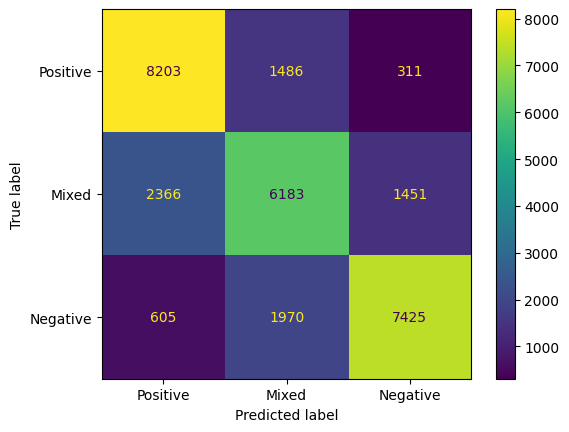

In [ ]:
cm = confusion_matrix(y_true=tests, y_pred=preds, labels=list(label_map))
cmd = ConfusionMatrixDisplay(cm, display_labels=list(label_map))
cmd.plot(values_format='')

In [ ]:
texts = [" الحياة لا باس بها" , 'اكره الغباء']

results = pipe(texts)

for idx, result in enumerate(results):
  print(texts[idx], result)

 الحياة لا باس بها {'label': 'Mixed', 'score': 0.4725610613822937}
اكره الغباء {'label': 'Negative', 'score': 0.7280571460723877}
